Студент : **Савин Александр**  
Группа : **М80-407Б-19**  
ЛР : **4**  

Статья - https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html  
Датасет - https://www.kaggle.com/datasets/gpiosenka/sports-classification  

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
train_path = "/content/drive/MyDrive/100Sports/train"
validation_path = "/content/MyDrive/drive/100Sports/val"
test_path = "/content/drive/MyDrive/100Sports/test"

image_categories = os.listdir('/content/drive/MyDrive/100Sports/train')

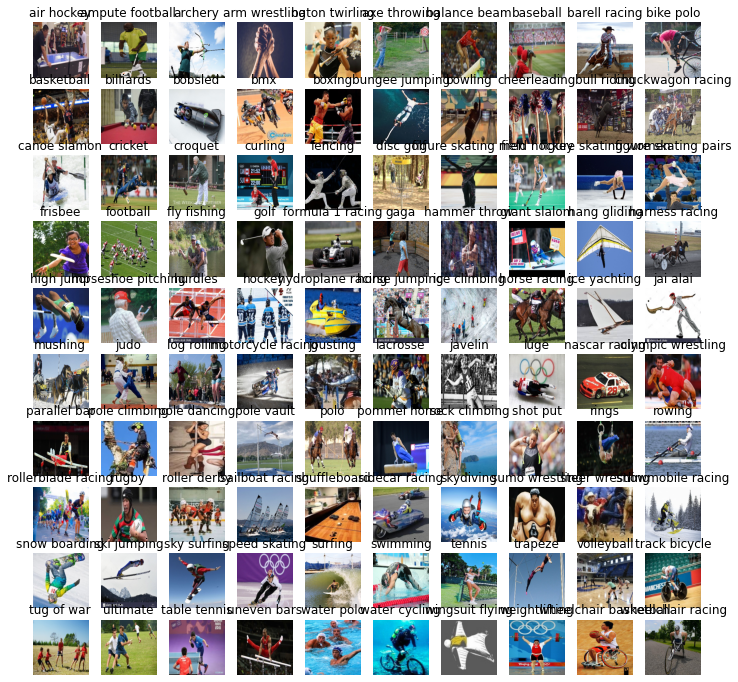

In [ ]:
# демонстрация содержимого датасета
import keras.utils as image
from keras.preprocessing.image import ImageDataGenerator
import os, shutil
import warnings
warnings.filterwarnings('ignore')
def plot_images(image_categories):
    # Создаем фигуру
    plt.figure(figsize=(12, 12))
    for i, v in enumerate(image_categories): # проходим по картинкам        
        # загружаем i-е изображение
        image_path = train_path + '/' + v
        images_in_folder = os.listdir(image_path)
        first_image_of_folder = images_in_folder[0]
        first_image_path = image_path + '/' + first_image_of_folder # создаем путь к изображению
        img = image.load_img(first_image_path)
        img_arr = image.img_to_array(img)/255.0 # преобразуем изображение в массив
        
        # Создаем subplot и строим изображение
        plt.subplot(10, 10, i+1)
        plt.imshow(img_arr)
        plt.title(v) # заголовок
        plt.axis('off')
        
    plt.show()

# Вызываем функцию отображения для заданной папки
plot_images(image_categories)

**Load Data**

In [ ]:
data_transforms = { # Задаем шаблон изменения изображения
    'train': transforms.Compose([ # Для тренировочных данных
        transforms.RandomResizedCrop(224), # Обрезать случайную часть изображения и преобразовать к заданному размеру
        transforms.RandomHorizontalFlip(), # Горизонтальный переворот
        transforms.ToTensor(),             # Преобразование в тензор
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Нормировка по заданным параметрам
    ]),
    'val': transforms.Compose([ # Для валидации
        transforms.Resize(256), #  Изменение размера
        transforms.CenterCrop(224), # Обрезка изображения в центре
        transforms.ToTensor(),      # Преобразование в тензор
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Нормировка по заданным параметрам
    ]),
}


In [ ]:
data_dir = '/content/drive/MyDrive/100Sports'  # адрес датасета
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), # Берем папки из заданной директории
                                          data_transforms[x]) # Применяем заданные трансформации
                  for x in ['train', 'val']} # К каждому элементу в двух категориях
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, # Dataloader нужен для распараллеливания загрузки данных, ускорения, экономии памяти
                                             shuffle=True, num_workers=4) for x in ['train', 'val']} # Применяем для обоих шаблонов

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']} # Длины датасетов
class_names = image_datasets['train'].classes # Имена классов

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Переключаемся на cuda, если это возможно

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
dataset_sizes

{'train': 13576, 'val': 500}

**Visualize a few images**



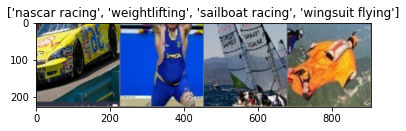

In [ ]:
def imshow(inp, title=None):
    # Вывод изображения для тензора
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp) # Отрисовка полученного изображения
    if title is not None: # Выводим название
        plt.title(title)
    plt.pause(0.001)  # пауза для обновления построений

# Берем батч из тренировочных данных
inputs, classes = next(iter(dataloaders['train']))
# Создаем сетку из батча
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes]) # Отправляем изображения на построение вместе с их названиями

**Training the model**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25): # Функция для тренировки модели
    since = time.time() # Засекаем начало

    best_model_wts = copy.deepcopy(model.state_dict()) # Сохраняем модель
    best_acc = 0.0 # Параметр для просчета лучшей точности

    for epoch in range(num_epochs): # Цикл по эпохам
        print(f'Epoch {epoch}/{num_epochs - 1}') # Вывод информации
        print('-' * 10)

        # Каждая эпоха имеет фазы тренировки и валидации
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Переводим модель в режим тренировки
            else:
                model.eval()   # Переводим модель в режим оценки (evaluate)

            running_loss = 0.0
            running_corrects = 0

            # Итерации по данным
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device) # Используем cuda
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # Выполняем операцию forward
                # История нам нужно только если проходим тренировку
                with torch.set_grad_enabled(phase == 'train'): # Выставляем опцию подсчета градиента в положение train
                    outputs = model(inputs) # отправляем входные данные в модель и получаем результат
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels) # Используем криетрий ошибки (в данном случае CrossEntropyLoss)

                    # Выполняем операцию backward и оптимизацию (только в фазе тренировки)
                    if phase == 'train':
                        loss.backward() # Выволняем операцию backward для ошибки
                        optimizer.step() # Обновляем параметры на основе высчитанных градиентов

                # Дополняем величины для подсчета статистики по обучению
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step() # Изменение lr

            epoch_loss = running_loss / dataset_sizes[phase]  # ошибка на эпохе
            epoch_acc = running_corrects.double() / dataset_sizes[phase] # точность на эпохе

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')  # Вывод информации

            # deep copy модели при достаточно хорошей точности
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since  # Считаем время, затраченное на тренировку
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s') # Вывод информации
    print(f'Best val Acc: {best_acc:4f}') # Вывод лучшей точности

    model.load_state_dict(best_model_wts) # Загружаем лучшую модель и возвращаем ее
    return model

**Visualizing the model predictions**

In [ ]:
def visualize_model(model, num_images=6): # визуализация тренировки на нескольких изображениях
    was_training = model.training  # сохраняем состояние
    model.eval() # переводим модель в режим eval
    images_so_far = 0 # счетчик
    fig = plt.figure() # фигура для построения

    with torch.no_grad(): # отключаем подсчет градиента для уменьшения потребления памяти
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device) # используем cuda
            labels = labels.to(device)

            outputs = model(inputs) # результат работы модели с входными данными
            _, preds = torch.max(outputs, 1) # Получаем максимальное значение среди элементов тензора
            
            for j in range(inputs.size()[0]):
                images_so_far += 1 # инкремент счетчика изображений
                ax = plt.subplot(num_images//2, 2, images_so_far) # выводим изображения
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}') # Задаем заголовок для изображения
                imshow(inputs.cpu().data[j]) # вывод изображения

                if images_so_far == num_images: # условия выхода
                    model.train(mode=was_training) # приводим модель в исходное состояние и выходим из функции
                    return
        model.train(mode=was_training)

**Finetuning the convnet**

In [ ]:
# Для данной задачи используем модель Resnet18
model_ft = models.resnet18(pretrained=True) # (pretrained=True) - Pytorch скачает параметры pretrained model и будет хранить их локально

num_ftrs = model_ft.fc.in_features # Задаем количество features
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names)) # задаем параметры модели на основе количества классов

model_ft = model_ft.to(device) # используем cuda для работы модели
criterion = nn.CrossEntropyLoss() # задаем функцию ошибки
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9) # задаем оптимизатор SGD с параметрами lr и momentum
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1) # Уменьшение lr каждые 7 эпох на гамму

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

**Train and evaluate**

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25) # запускаем тренировку модели с заданными параметрами

Epoch 0/24
----------
train Loss: 2.7242 Acc: 0.3332
val Loss: 0.7203 Acc: 0.7920

Epoch 1/24
----------
train Loss: 1.8379 Acc: 0.5165
val Loss: 0.5377 Acc: 0.8340

Epoch 2/24
----------
train Loss: 1.6129 Acc: 0.5797
val Loss: 0.4469 Acc: 0.8600

Epoch 3/24
----------
train Loss: 1.4863 Acc: 0.6090
val Loss: 0.4889 Acc: 0.8520

Epoch 4/24
----------
train Loss: 1.3608 Acc: 0.6375
val Loss: 0.4344 Acc: 0.8780

Epoch 5/24
----------
train Loss: 1.2931 Acc: 0.6607
val Loss: 0.3875 Acc: 0.8960

Epoch 6/24
----------
train Loss: 1.2251 Acc: 0.6775
val Loss: 0.3809 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.9029 Acc: 0.7630
val Loss: 0.2389 Acc: 0.9440

Epoch 8/24
----------
train Loss: 0.8041 Acc: 0.7882
val Loss: 0.2347 Acc: 0.9480

Epoch 9/24
----------
train Loss: 0.7645 Acc: 0.8015
val Loss: 0.2164 Acc: 0.9460

Epoch 10/24
----------
train Loss: 0.7374 Acc: 0.8065
val Loss: 0.2134 Acc: 0.9460

Epoch 11/24
----------
train Loss: 0.7067 Acc: 0.8139
val Loss: 0.2197 Acc: 0.9500

Ep

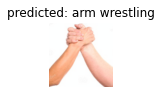

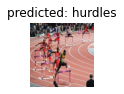

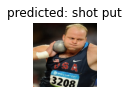

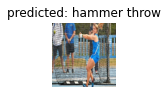

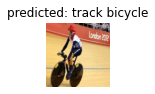

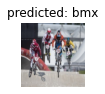

In [ ]:
visualize_model(model_ft) # отображаем результат работы программы

**ConvNet as fixed feature extractor**

In [ ]:
# Для данной задачи используем модель Resnet18
model_conv = torchvision.models.resnet18(pretrained=True) # (pretrained=True) - Pytorch скачает параметры pretrained model и будет хранить их локально
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features # Задаем количество features
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_conv.fc = nn.Linear(num_ftrs, len(class_names)) # задаем параметры модели на основе количества классов
model_conv = model_conv.to(device) # используем cuda для работы модели
criterion = nn.CrossEntropyLoss() # задаем функцию ошибки

# Здесь оптимизируются только параметры конечного слоя, в отличии от предыдущей модели.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9) # задаем оптимизатор SGD с параметрами lr и momentum
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)  # Уменьшение lr каждые 7 эпох на гамму

**Train and evaluate**

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25) # запускаем тренировку модели с заданными параметрами

Epoch 0/24
----------
train Loss: 3.1831 Acc: 0.2755
val Loss: 1.0052 Acc: 0.7380

Epoch 1/24
----------
train Loss: 2.0893 Acc: 0.4848
val Loss: 0.6683 Acc: 0.8020

Epoch 2/24
----------
train Loss: 1.7989 Acc: 0.5457
val Loss: 0.5875 Acc: 0.8220

Epoch 3/24
----------
train Loss: 1.6544 Acc: 0.5745
val Loss: 0.5066 Acc: 0.8260

Epoch 4/24
----------
train Loss: 1.5795 Acc: 0.5911
val Loss: 0.4773 Acc: 0.8500

Epoch 5/24
----------
train Loss: 1.5367 Acc: 0.6002
val Loss: 0.4663 Acc: 0.8680

Epoch 6/24
----------
train Loss: 1.5132 Acc: 0.6075
val Loss: 0.4313 Acc: 0.8620

Epoch 7/24
----------
train Loss: 1.3646 Acc: 0.6497
val Loss: 0.3717 Acc: 0.8760

Epoch 8/24
----------
train Loss: 1.3414 Acc: 0.6517
val Loss: 0.3809 Acc: 0.8880

Epoch 9/24
----------
train Loss: 1.3477 Acc: 0.6506
val Loss: 0.3690 Acc: 0.8860

Epoch 10/24
----------
train Loss: 1.3277 Acc: 0.6542
val Loss: 0.3645 Acc: 0.8880

Epoch 11/24
----------
train Loss: 1.3149 Acc: 0.6577
val Loss: 0.3803 Acc: 0.8900

Ep

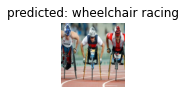

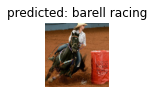

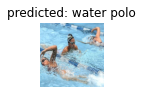

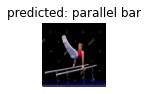

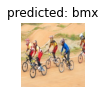

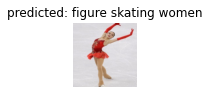

In [ ]:
visualize_model(model_conv) # отображаем результат

plt.ioff()
plt.show()